In [1]:
import glob
import matplotlib.pyplot as plt


from cov_nerf.utils.ray_utils import *
from cov_nerf.utils.geom_utils import *
from cov_nerf.model import CovNerf, NerfObject

from torch_utils import *
import vis

torch.set_grad_enabled(False)

## Load the model, objects, background scene info

In [2]:
model = CovNerf().cuda().eval()
ckpt = torch.load("checkpoints/cov_nerf.pt", map_location="cpu")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [3]:
objects = [
    NerfObject.load(fname).to("cuda") for fname in glob.glob("assets/object_*.pt")
]

In [4]:
bg_scene = torch.load("assets/bg_scene.pt", map_location="cpu")
bg_scene = to_torch(bg_scene, device="cuda", recursive=True)

bg_rgbs = bg_scene["rgbs"][1:]
bg_intrinsics = bg_scene["intrinsics"][1:]
bg_world_from_cams = bg_scene["world_from_cams"][1:]

target_intrinsic = bg_scene["intrinsics"][0]
target_world_from_cam = bg_scene["world_from_cams"][0]
target_near_plane = bg_scene["near_plane"]
target_far_plane = bg_scene["far_plane"]
target_im_size = (640, 896)

## Render the current scene

Plot the rendered RGB, instance masks, depth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:28<00:00,  4.95it/s]


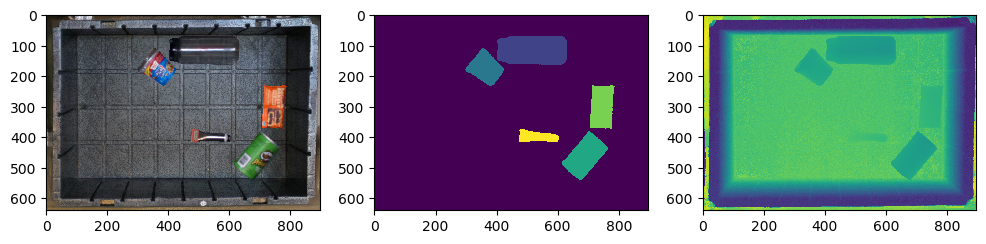

In [5]:
out = model.render(
    objects,
    # target camera info
    target_intrinsic=target_intrinsic,
    target_world_from_cam=target_world_from_cam,
    target_near_plane=target_near_plane,
    target_far_plane=target_far_plane,
    target_im_size=target_im_size,
    # bg source images
    bg_src_rgbs=bg_rgbs,
    bg_src_intrinsics=bg_intrinsics,
    bg_src_world_from_cams=bg_world_from_cams,
)
plt.figure(figsize=(12, 8))
plt.subplot(131)
vis.plot_rgb(out["rgb"])

plt.subplot(132)
id_mask = out["segm"].argmax(0) + out["segm"].any(0) - 1
plt.imshow(to_np(id_mask))

plt.subplot(133)
plt.imshow(to_np(out["depth"]))

## Manipulate the scene & re-render

Showcasing:
* Explict pose manipulation (rotation/translation)
* Re-scale object size
* Duplicate and/or remove objects

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:21<00:00,  6.64it/s]


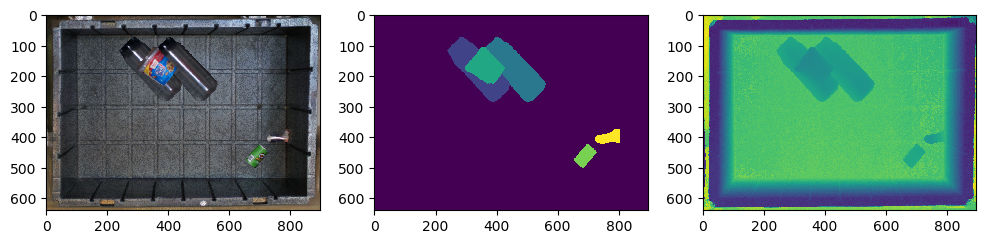

In [6]:
def move(pose: torch.tensor, pos=None, quat=None):
    new_pose = pose.clone()
    if quat is not None:
        quat = torch.tensor(quat, dtype=torch.float32, device=pose.device)
        rotmat = quat_to_rotation_matrix(quat)
        new_pose[:3, :3] = rotmat @ new_pose[:3, :3]

    if pos is not None:
        pos = torch.tensor(pos, dtype=torch.float32, device=pose.device)
        new_pose[:3, 3] += pos

    return new_pose


new_objects = [
    # duplicate and translate/rotate
    attr.evolve(
        objects[0],
        pose=move(objects[0].pose, pos=[-0.15, 0.05, 0], quat=[0.9238, 0, 0, 0.3826]),
    ),
    attr.evolve(
        objects[0],
        pose=move(objects[0].pose, pos=[-0.05, 0.05, 0], quat=[0.9238, 0, 0, 0.3826]),
    ),
    # stack on top of others
    attr.evolve(
        objects[1],
        pose=move(objects[1].pose, pos=[0, 0, -0.5 * objects[0].dimension[2].item()]),
    ),
    # rescale, same pose
    attr.evolve(objects[2], dimension=0.5 * objects[2].dimension),
    # delete from the scene
    # objects[3]
    # translate/rotate
    attr.evolve(
        objects[4],
        pose=move(objects[4].pose, pos=[0.2, 0, -0.05], quat=[0.5, 0, 0.866, 0]),
    ),
]
out = model.render(
    new_objects,
    # target camera info
    target_intrinsic=target_intrinsic,
    target_world_from_cam=target_world_from_cam,
    target_near_plane=target_near_plane,
    target_far_plane=target_far_plane,
    target_im_size=target_im_size,
    # bg source images
    bg_src_rgbs=bg_rgbs,
    bg_src_intrinsics=bg_intrinsics,
    bg_src_world_from_cams=bg_world_from_cams,
)
plt.figure(figsize=(12, 8))
plt.subplot(131)
vis.plot_rgb(out["rgb"])

plt.subplot(132)
id_mask = out["segm"].argmax(0) + out["segm"].any(0) - 1
plt.imshow(to_np(id_mask))

plt.subplot(133)
plt.imshow(to_np(out["depth"]))